In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [135]:
df = pd.read_csv('preds_master-testset_phi-4_master-large.csv')

In [136]:
df['model'] = df['model'].str.replace("Instruct", "")
df['model'] = df['model'].str.replace("instruct", "")
df['model'] = df['model'].str.replace("Meta-", "")
df['model'] = df['model'].str.replace("-AWQ", "")
df['model'] = df['model'].str.replace("-INT4", "")
df['model'] = df['model'].str.replace("--", "-")
df["model"] = df["model"].str.replace("-128k", "")
df['model'] = df['model'].str.replace("2025-04-14", "")
df['model'] = df['model'].str.replace("-2407", "")
df['model'] = df['model'].str.replace("-2410", "")
df['model'] = df['model'].str.rstrip("-")

In [137]:
df["bin_preds"] = df["preds"].apply(lambda x: 1 if x > 0.5 else 0)
df

,preds,data,model,label,bin_preds
0,1.000000,nyt-comments,Llama-3.1-8B,1,1
1,1.000000,nyt-comments,Llama-3.1-8B,1,1
2,0.999966,nyt-comments,Llama-3.1-8B,1,1
3,0.999999,nyt-comments,Llama-3.1-8B,1,1
4,0.995071,nyt-comments,Llama-3.1-8B,1,1
...,...,...,...,...,...
357627,0.999973,essays,Phi-3-small,1,1
357628,0.999970,essays,Phi-3-small,1,1
357629,0.999996,essays,Phi-3-small,1,1
357630,0.999997,essays,Phi-3-small,1,1


In [138]:
custom_order = [
    "human",
    "gpt-4.1-nano",
    "Llama-3.1-8B",
    "Llama-3.1-70B",
    "Llama-3.2-3B",
    "Llama-3.3-70B",
    "Phi-3-mini",
    "Phi-3-small",
    "Phi-3-medium",
    "Phi-3.5-mini",
    "Phi-4-mini",
    "phi-4",
    "Ministral-8B",
    "Mistral-Nemo",
    "Qwen2-7B",
    "Qwen2-72B",
    "Qwen2.5-3B",
    "Qwen2.5-7B",
    "Qwen2.5-14B",
    "Qwen2.5-72B",
    "Falcon3-3B",
    "Falcon3-7B"
]

In [139]:
accuracy_df = (
    df.groupby(['model', 'data'])
    .apply(lambda x: (x['bin_preds'] == x['label']).mean())
    .reset_index(name='accuracy')
)

# Step 2: Pivot for heatmap
pivot = accuracy_df.pivot(index='model', columns='data', values='accuracy')
pivot = pivot.reindex(index=custom_order)

/tmp/ipykernel_173803/3373099195.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['bin_preds'] == x['label']).mean())


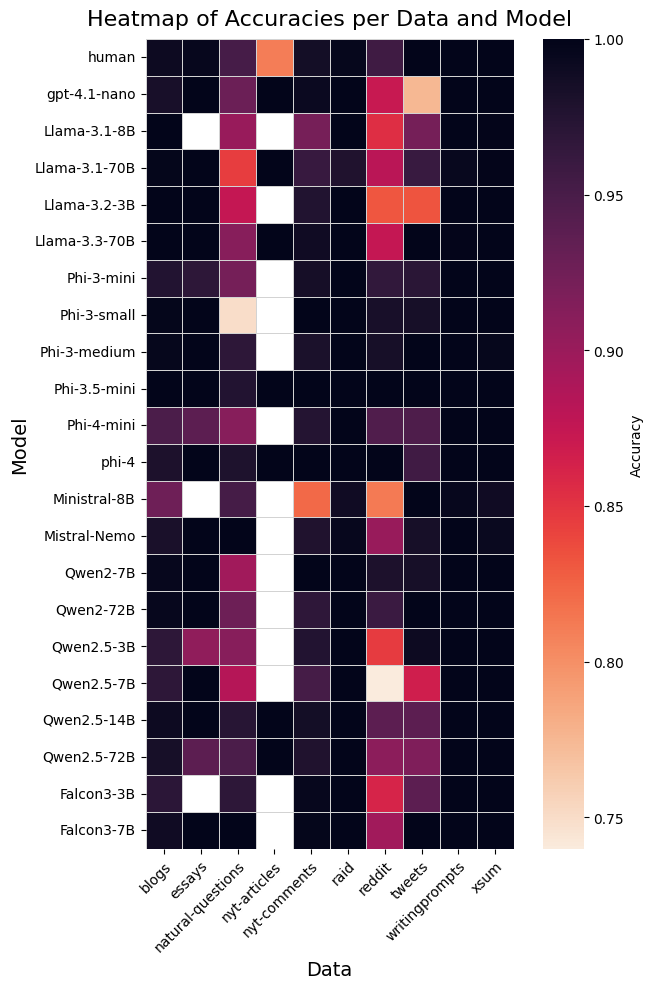

In [140]:
fig, ax = plt.subplots(figsize=(15, 10))  # Use subplots for better axis control

sns.heatmap(
    pivot,
    fmt=".2g",
    cmap=sns.color_palette("rocket_r", as_cmap=True),
    cbar_kws={'label': 'Accuracy', 'shrink': 1, 'pad': 0.02},
    linewidths=0.5,
    linecolor='lightgray',
    square=True,
    ax=ax
)

# Axis titles and styling
ax.set_title("Heatmap of Accuracies per Data and Model", fontsize=16, pad=10)
ax.set_xlabel("Data", fontsize=14)
ax.set_ylabel("Model", fontsize=14)

# Set x-axis tick labels with rotation and style
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor",
    fontsize=10
)

# Set y-axis tick label font size
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize=10
)

fig.tight_layout()
plt.show()


In [165]:
# get all file path in the current directory with "large" in the name
import os
def get_large_files():
    files = []
    for file in os.listdir('.'):
        files.append(file)
    return files

In [166]:
paths = get_large_files()

In [143]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score
import numpy as np

In [145]:
paths_filtered = [path for path in paths if "detect" in path and "hard" not in path]

In [146]:
# collect preds from all files, 
def collect_preds(paths):
    preds = []
    for path in paths:
        df = pd.read_csv(path)
        preds.append(df['preds'].tolist())
        labels = df['label'].tolist()
    return preds, labels

In [147]:
preds, labels = collect_preds(paths_filtered)

In [148]:
preds_array = np.array(preds).T
labels_array = np.array(labels)

In [149]:
preds_bin = (preds_array > 0.5).any(axis=1).astype(int)

In [150]:
acc = accuracy_score(labels_array, preds_bin)
bal_acc = balanced_accuracy_score(labels_array, preds_bin)
prec = precision_score(labels_array, preds_bin)
rec = recall_score(labels_array, preds_bin)
f1 = f1_score(labels_array, preds_bin)
roc_auc = roc_auc_score(labels_array, preds_array.mean(axis=1))

In [151]:
print(f"Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.7126
Balanced Accuracy: 0.6874
Precision: 0.6559
Recall: 0.9878
F1 Score: 0.7883
ROC AUC: 0.7907


In [152]:
df = pd.read_csv(paths_filtered[0])

In [153]:
df["bin_preds"] = preds_bin

In [154]:
df['model'] = df['model'].str.replace("Instruct", "")
df['model'] = df['model'].str.replace("instruct", "")
df['model'] = df['model'].str.replace("Meta-", "")
df['model'] = df['model'].str.replace("-AWQ", "")
df['model'] = df['model'].str.replace("-INT4", "")
df['model'] = df['model'].str.replace("--", "-")
df["model"] = df["model"].str.replace("-128k", "")
df['model'] = df['model'].str.replace("2025-04-14", "")
df['model'] = df['model'].str.replace("-2407", "")
df['model'] = df['model'].str.replace("-2410", "")
df['model'] = df['model'].str.rstrip("-")

In [155]:
accuracy_df = (
    df.groupby(['model', 'data'])
    .apply(lambda x: (x['bin_preds'] == x['label']).mean())
    .reset_index(name='accuracy')
)

# Step 2: Pivot for heatmap
pivot = accuracy_df.pivot(index='model', columns='data', values='accuracy')
pivot = pivot.reindex(index=custom_order)

/tmp/ipykernel_173803/3373099195.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['bin_preds'] == x['label']).mean())


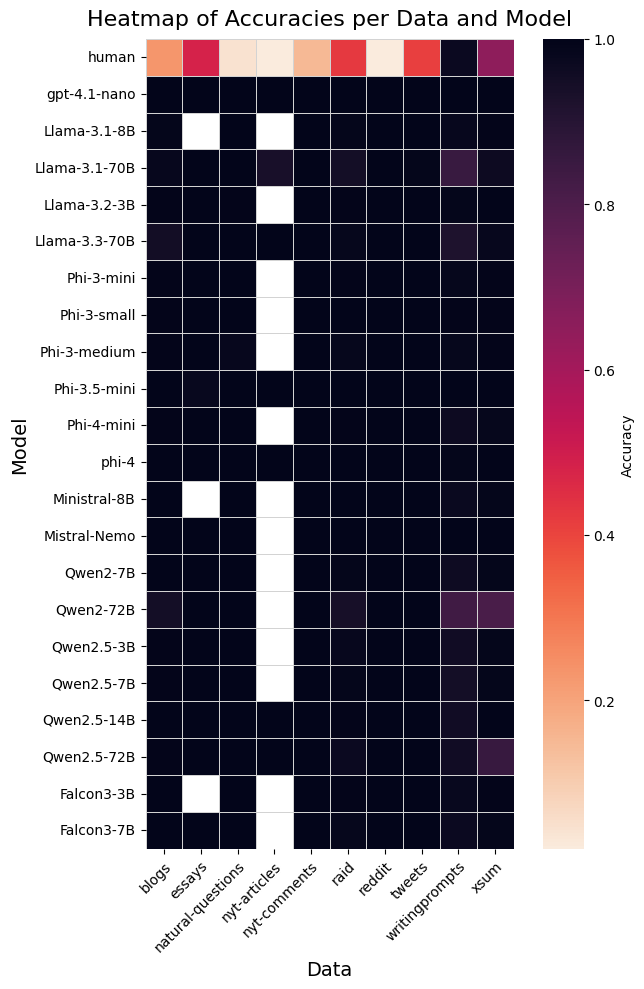

In [156]:
fig, ax = plt.subplots(figsize=(15, 10))  # Use subplots for better axis control

sns.heatmap(
    pivot,
    fmt=".2g",
    cmap=sns.color_palette("rocket_r", as_cmap=True),
    cbar_kws={'label': 'Accuracy', 'shrink': 1, 'pad': 0.02},
    linewidths=0.5,
    linecolor='lightgray',
    square=True,
    ax=ax
)

# Axis titles and styling
ax.set_title("Heatmap of Accuracies per Data and Model", fontsize=16, pad=10)
ax.set_xlabel("Data", fontsize=14)
ax.set_ylabel("Model", fontsize=14)

# Set x-axis tick labels with rotation and style
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor",
    fontsize=10
)

# Set y-axis tick label font size
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize=10
)

fig.tight_layout()
plt.show()


In [100]:
for level in range(6):
    paths_filtered = [path for path in paths if "detect" in path and f"hard-{level}" in path]
    preds, labels = collect_preds(paths_filtered)
    preds_array = np.array(preds).T
    labels_array = np.array(labels)
    preds_bin = (preds_array > 0.5).any(axis=1).astype(int)
    acc = accuracy_score(labels_array, preds_bin)
    bal_acc = balanced_accuracy_score(labels_array, preds_bin)
    prec = precision_score(labels_array, preds_bin)
    rec = recall_score(labels_array, preds_bin)
    f1 = f1_score(labels_array, preds_bin)
    print(f"Hard-{level}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

/home/majkel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/majkel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Hard-0
Accuracy: 0.9869
Balanced Accuracy: 0.9869
Precision: 1.0000
Recall: 0.9869
F1 Score: 0.9934
Hard-1
Accuracy: 0.9323
Balanced Accuracy: 0.9323
Precision: 1.0000
Recall: 0.9323
F1 Score: 0.9650


/home/majkel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/majkel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Hard-2
Accuracy: 0.9391
Balanced Accuracy: 0.9391
Precision: 1.0000
Recall: 0.9391
F1 Score: 0.9686
Hard-3
Accuracy: 0.9279
Balanced Accuracy: 0.9279
Precision: 1.0000
Recall: 0.9279
F1 Score: 0.9626
Hard-4
Accuracy: 0.9358
Balanced Accuracy: 0.9358
Precision: 1.0000
Recall: 0.9358
F1 Score: 0.9668
Hard-5
Accuracy: 0.9354
Balanced Accuracy: 0.9354
Precision: 1.0000
Recall: 0.9354
F1 Score: 0.9666


/home/majkel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/majkel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [182]:
paths_filtered = [path for path in paths if ("detect" in path and "hard" not in path and "family" in path) or ("gpt" in path and "hard" not in path)]
paths_filtered

['preds_master-testset_Mistral-Nemo-Instruct-2407_detect-mistral-family.csv',
 'preds_master-testset_phi-4_detect-gpt-4.1-nano-2025-04-14.csv',
 'preds_master-testset_Llama-3.1-8B-Instruct_detect-llama-family.csv',
 'preds_master-testset_Qwen2.5-14B-Instruct_detect-qwen-family.csv',
 'preds_master-testset_Falcon3-7B-Instruct_detect-falcon-family.csv',
 'preds_master-testset_phi-4_detect-phi-family.csv']

In [168]:
preds, labels = collect_preds(paths_filtered)

In [169]:
preds_array = np.array(preds).T
labels_array = np.array(labels)

In [170]:
preds_bin = (preds_array > 0.5).any(axis=1).astype(int)

In [171]:
acc = accuracy_score(labels_array, preds_bin)
bal_acc = balanced_accuracy_score(labels_array, preds_bin)
prec = precision_score(labels_array, preds_bin)
rec = recall_score(labels_array, preds_bin)
f1 = f1_score(labels_array, preds_bin)
roc_auc = roc_auc_score(labels_array, preds_array.mean(axis=1))

In [172]:
print(f"Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.8061
Balanced Accuracy: 0.7920
Precision: 0.7510
Recall: 0.9609
F1 Score: 0.8431
ROC AUC: 0.8665


In [173]:
df = pd.read_csv(paths_filtered[0])

In [174]:
df["bin_preds"] = preds_bin

In [175]:
df['model'] = df['model'].str.replace("Instruct", "")
df['model'] = df['model'].str.replace("instruct", "")
df['model'] = df['model'].str.replace("Meta-", "")
df['model'] = df['model'].str.replace("-AWQ", "")
df['model'] = df['model'].str.replace("-INT4", "")
df['model'] = df['model'].str.replace("--", "-")
df["model"] = df["model"].str.replace("-128k", "")
df['model'] = df['model'].str.replace("2025-04-14", "")
df['model'] = df['model'].str.replace("-2407", "")
df['model'] = df['model'].str.replace("-2410", "")
df['model'] = df['model'].str.rstrip("-")

In [176]:
accuracy_df = (
    df.groupby(['model', 'data'])
    .apply(lambda x: (x['bin_preds'] == x['label']).mean())
    .reset_index(name='accuracy')
)

# Step 2: Pivot for heatmap
pivot = accuracy_df.pivot(index='model', columns='data', values='accuracy')
pivot = pivot.reindex(index=custom_order)

/tmp/ipykernel_173803/3373099195.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['bin_preds'] == x['label']).mean())


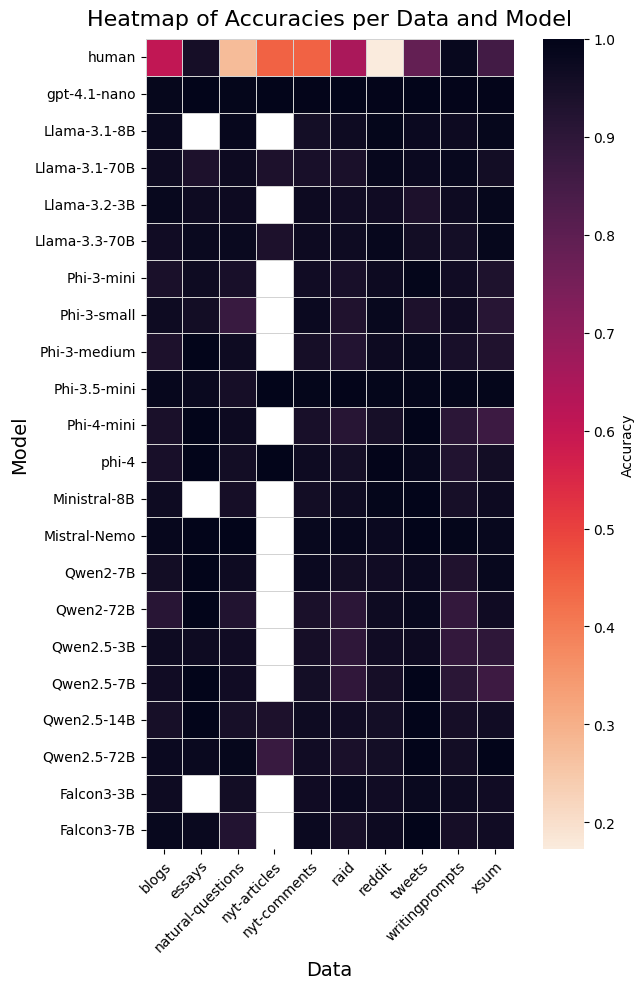

In [177]:
fig, ax = plt.subplots(figsize=(15, 10))  # Use subplots for better axis control

sns.heatmap(
    pivot,
    fmt=".2g",
    cmap=sns.color_palette("rocket_r", as_cmap=True),
    cbar_kws={'label': 'Accuracy', 'shrink': 1, 'pad': 0.02},
    linewidths=0.5,
    linecolor='lightgray',
    square=True,
    ax=ax
)

# Axis titles and styling
ax.set_title("Heatmap of Accuracies per Data and Model", fontsize=16, pad=10)
ax.set_xlabel("Data", fontsize=14)
ax.set_ylabel("Model", fontsize=14)

# Set x-axis tick labels with rotation and style
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor",
    fontsize=10
)

# Set y-axis tick label font size
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize=10
)

fig.tight_layout()
plt.show()

In [180]:
for level in range(6):
    paths_filtered = [path for path in paths if ("detect" in path and f"hard-{level}" in path and "family" in path) or ("gpt" in path and f"hard-{level}" in path)]
    preds, labels = collect_preds(paths_filtered)
    preds_array = np.array(preds).T
    labels_array = np.array(labels)
    preds_bin = (preds_array > 0.5).any(axis=1).astype(int)
    acc = accuracy_score(labels_array, preds_bin)
    bal_acc = balanced_accuracy_score(labels_array, preds_bin)
    prec = precision_score(labels_array, preds_bin)
    rec = recall_score(labels_array, preds_bin)
    f1 = f1_score(labels_array, preds_bin)
    print(f"Hard-{level}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

/home/majkel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/majkel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/majkel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/majkel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Hard-0
Accuracy: 0.9590
Balanced Accuracy: 0.9590
Precision: 1.0000
Recall: 0.9590
F1 Score: 0.9791
Hard-1
Accuracy: 0.8535
Balanced Accuracy: 0.8535
Precision: 1.0000
Recall: 0.8535
F1 Score: 0.9210
Hard-2
Accuracy: 0.8677
Balanced Accuracy: 0.8677
Precision: 1.0000
Recall: 0.8677
F1 Score: 0.9292
Hard-3
Accuracy: 0.8300
Balanced Accuracy: 0.8300
Precision: 1.0000
Recall: 0.8300
F1 Score: 0.9071
Hard-4
Accuracy: 0.8622
Balanced Accuracy: 0.8622
Precision: 1.0000
Recall: 0.8622
F1 Score: 0.9260
Hard-5
Accuracy: 0.8448
Balanced Accuracy: 0.8448
Precision: 1.0000
Recall: 0.8448
F1 Score: 0.9159


/home/majkel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/majkel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
